Analyse des données

Préparation des données avec pandas


In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import plotly.express as px
import pandas as pd

pd.set_option('display.float_format', lambda x: f'{x :.2f}')
from cleaner import DataCleaner
from get_dataframes import GetDataframes
import hjson

from datetime import datetime

import matplotlib.pyplot as plt
import explo_data_analysis.eda_movies as eda

with open("config.hjson") as fp:
    config = hjson.load(fp)

In [2]:
datas = GetDataframes(config)
link = "movies"
df = datas.get_dataframes(
    link,
)

2023-10-30 10:52:42 INFO     Parquet loaded ! Importing movies...
2023-10-30 10:52:42 INFO     Dataframe movies ready to use!


In [3]:
df.head()

,titre_id,titre_str,titre_date_sortie,titre_duree,titre_genres,rating_avg,rating_votes,original_language,original_title,popularity,production_countries,revenue,spoken_languages,status,region,cuts
0,tt0000591,The Prodigal Son,1907,90,[Drama],5.00,21,fr,L'enfant prodigue,0.60,[FR],0.00,[xx],Released,FR,1900-1909
1,tt0001790,"Les Misérables, Part 1: Jean Valjean",1913,60,[Drama],6.00,52,en,Les misérables - Époque 1: Jean Valjean,0.87,[FR],0.00,[fr],Released,FR,1910-1919
2,tt0002130,Dante's Inferno,1911,71,"[Adventure, Drama, Fantasy]",7.00,3267,it,L’Inferno,5.39,[IT],0.00,[xx],Released,FR,1910-1919
3,tt0002199,From the Manger to the Cross,1912,60,"[Biography, Drama]",5.80,621,en,From the Manger to the Cross,1.16,[US],0.00,[xx],Released,FR,1910-1919
4,tt0002423,Passion,1919,85,"[Biography, Drama, Romance]",6.60,968,de,Madame DuBarry,1.84,[DE],0.00,[xx],Released,FR,1910-1919


ADD TMDB
AND
AKAS

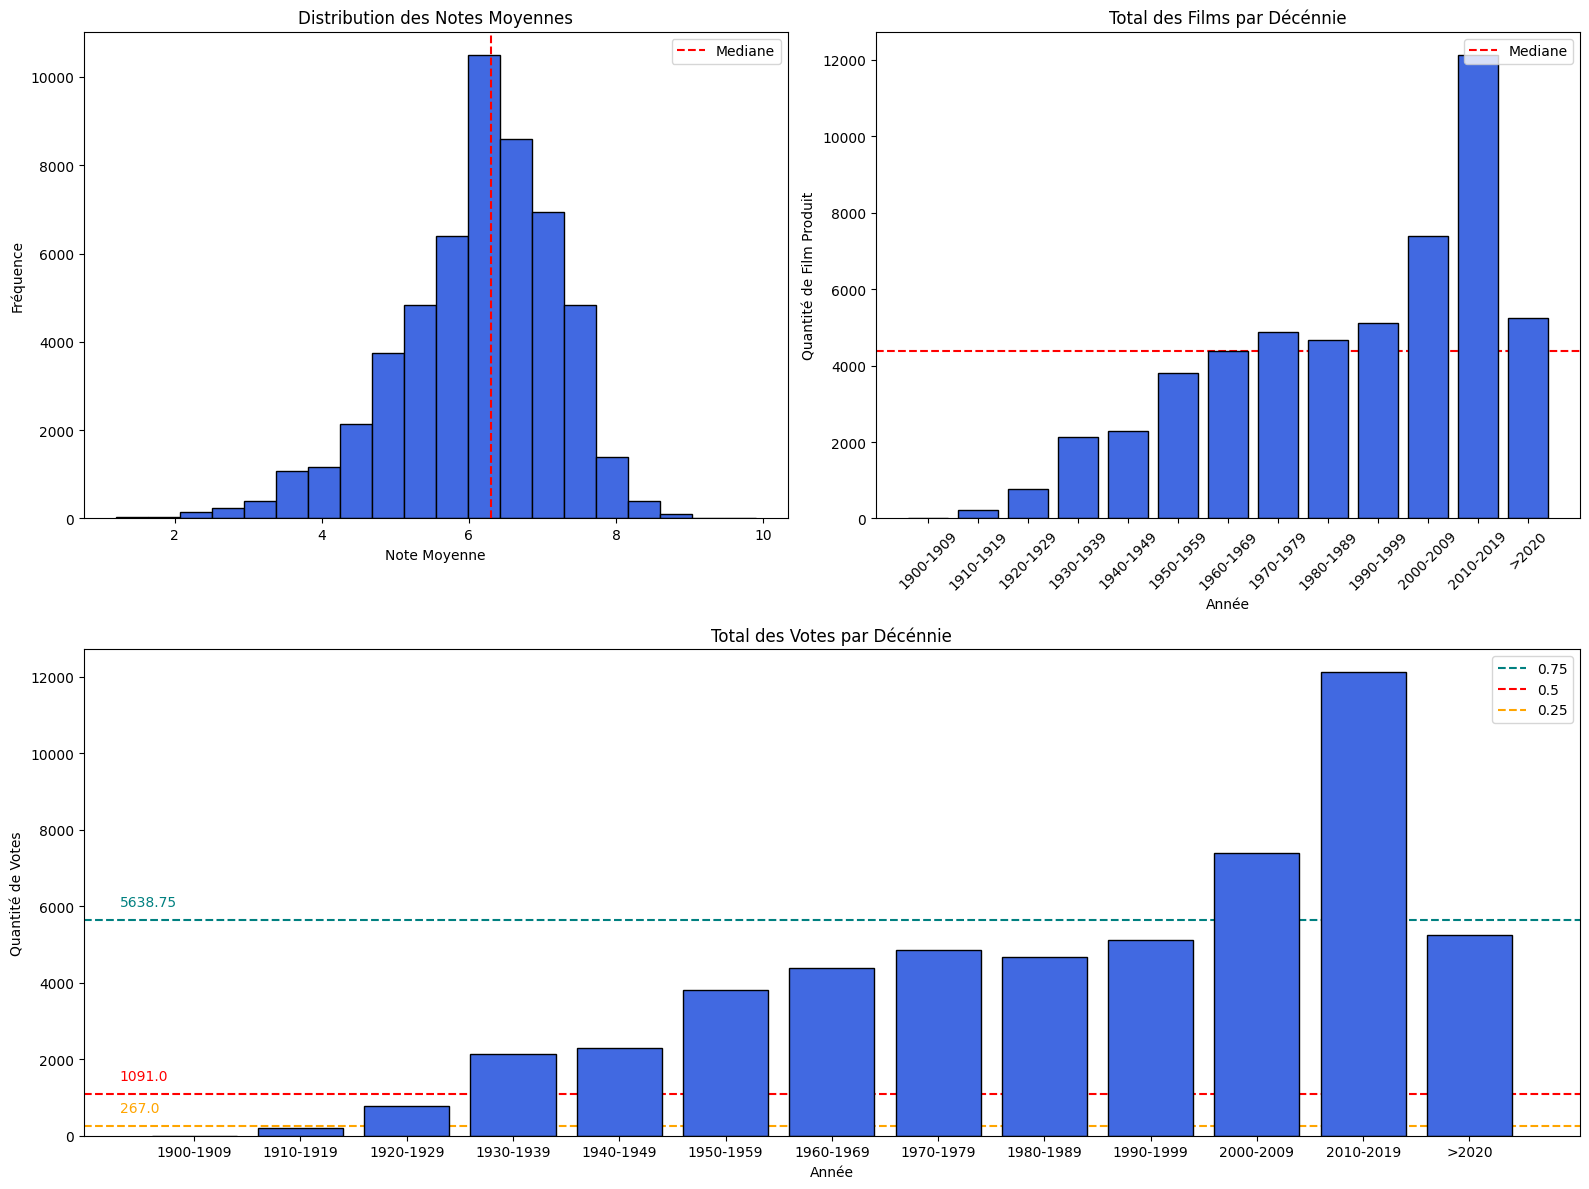

In [4]:
eda.show_total_films_decade(df)

**A partir d'ici nous pouvons definir notre angle d'attaque**
=


**Delete les films en dessous de 1960**

In [5]:
condi =(
    (df["titre_date_sortie"] >= 1960) &
    (df["rating_avg"] >= 5)
)
df = df[condi].reset_index(drop='index')

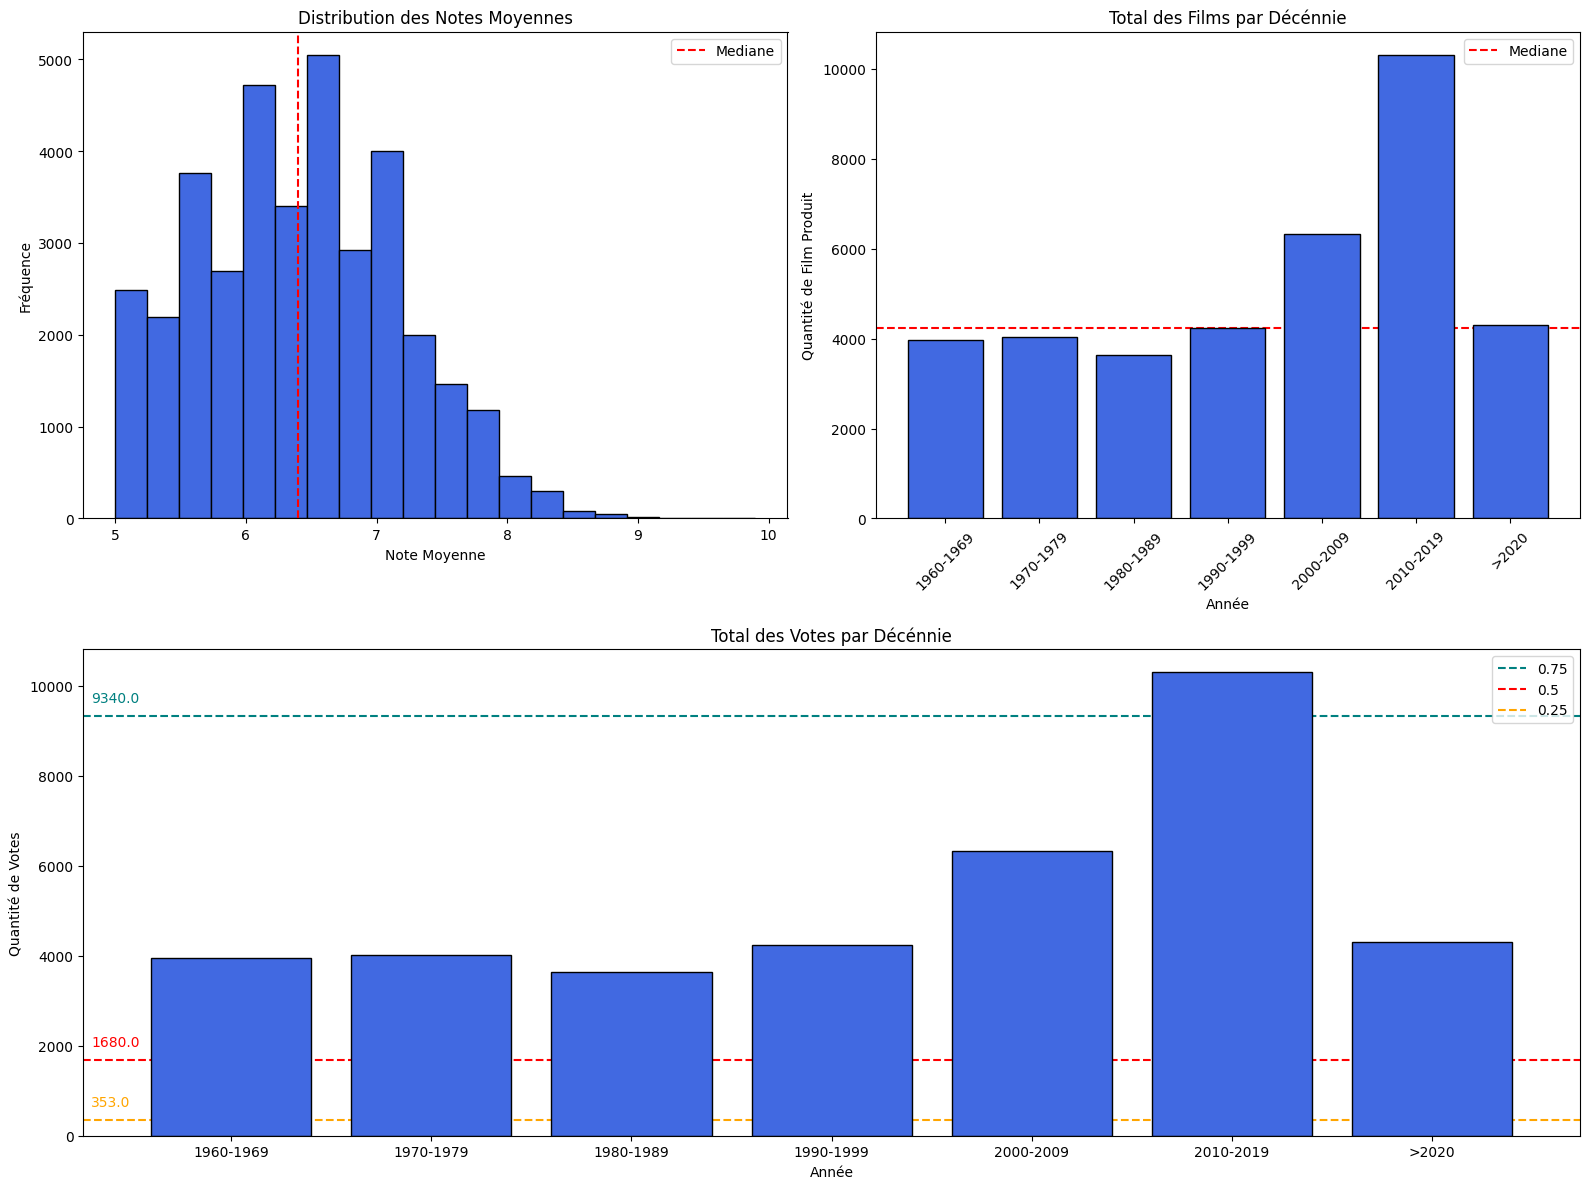

In [6]:
eda.show_total_films_decade(df)

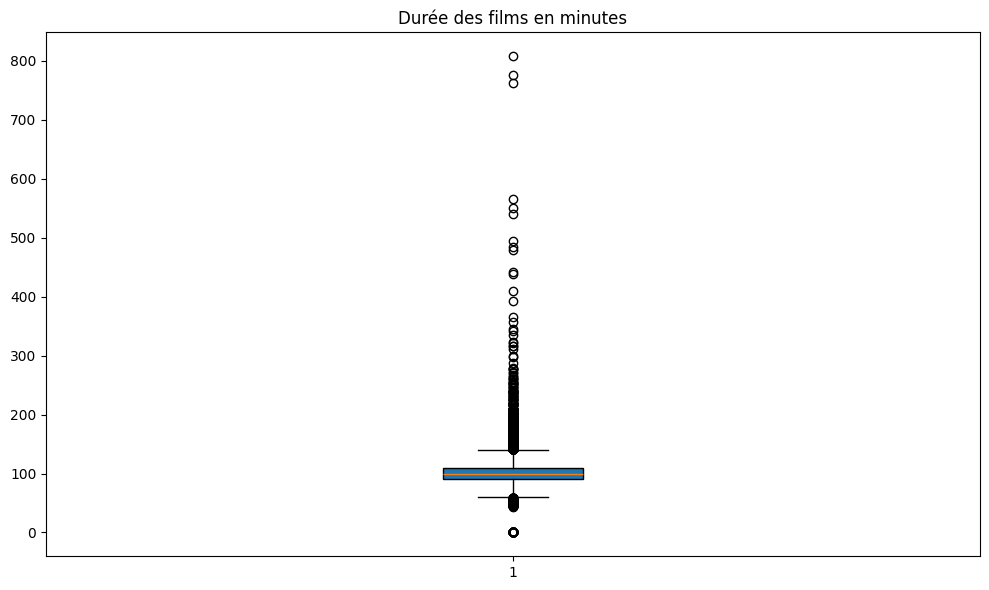

In [7]:
plt.figure(figsize=(10, 6))
plt.boxplot(
    df["titre_duree"],
    patch_artist=True
)
plt.title("Durée des films en minutes")
plt.tight_layout()
plt.show()

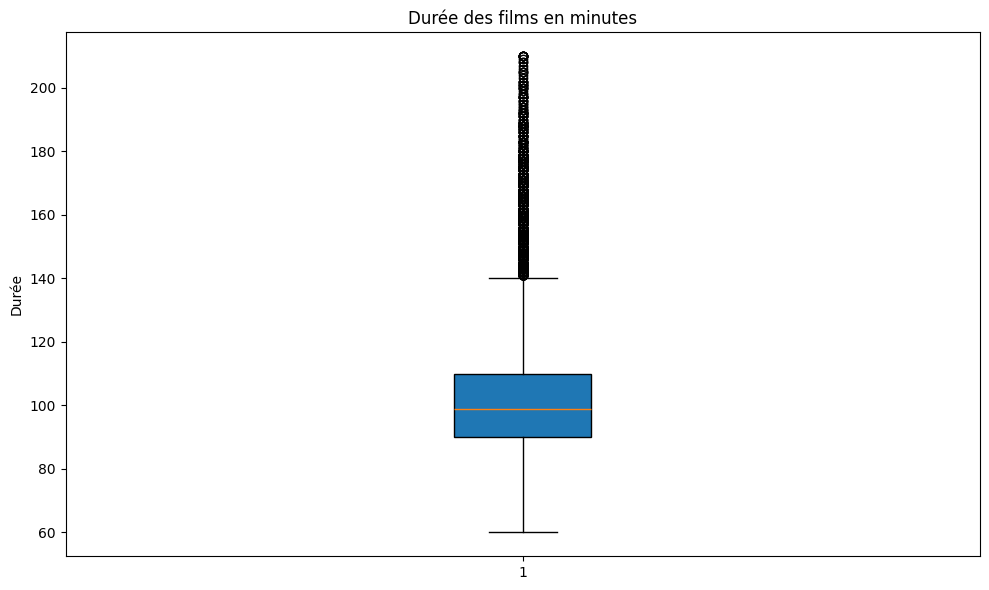

In [8]:
condi =(
    (df["titre_duree"] < 60) | (df["titre_duree"] > 210)
)
df = df[~condi].reset_index(drop='index')
df

plt.figure(figsize=(10, 6))
plt.boxplot(
    df["titre_duree"],
    patch_artist=True
)
plt.ylabel("Durée")
plt.title("Durée des films en minutes")
plt.tight_layout()
plt.show()

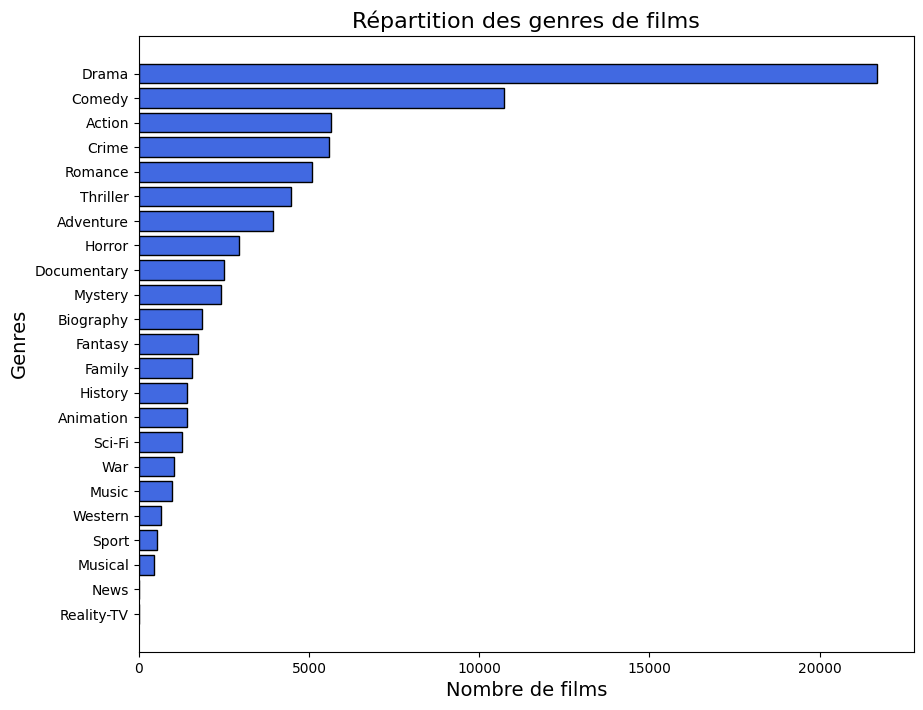

In [9]:
total_genres = df.explode('titre_genres')['titre_genres'].value_counts()

plt.figure(figsize=(10, 8))
plt.barh(
    total_genres.index,
    total_genres.values,
    color='royalblue',
    edgecolor='black'
)
plt.title('Répartition des genres de films', fontsize=16)
plt.xlabel('Nombre de films', fontsize=14)
plt.ylabel('Genres', fontsize=14)
plt.gca().invert_yaxis()
plt.show()

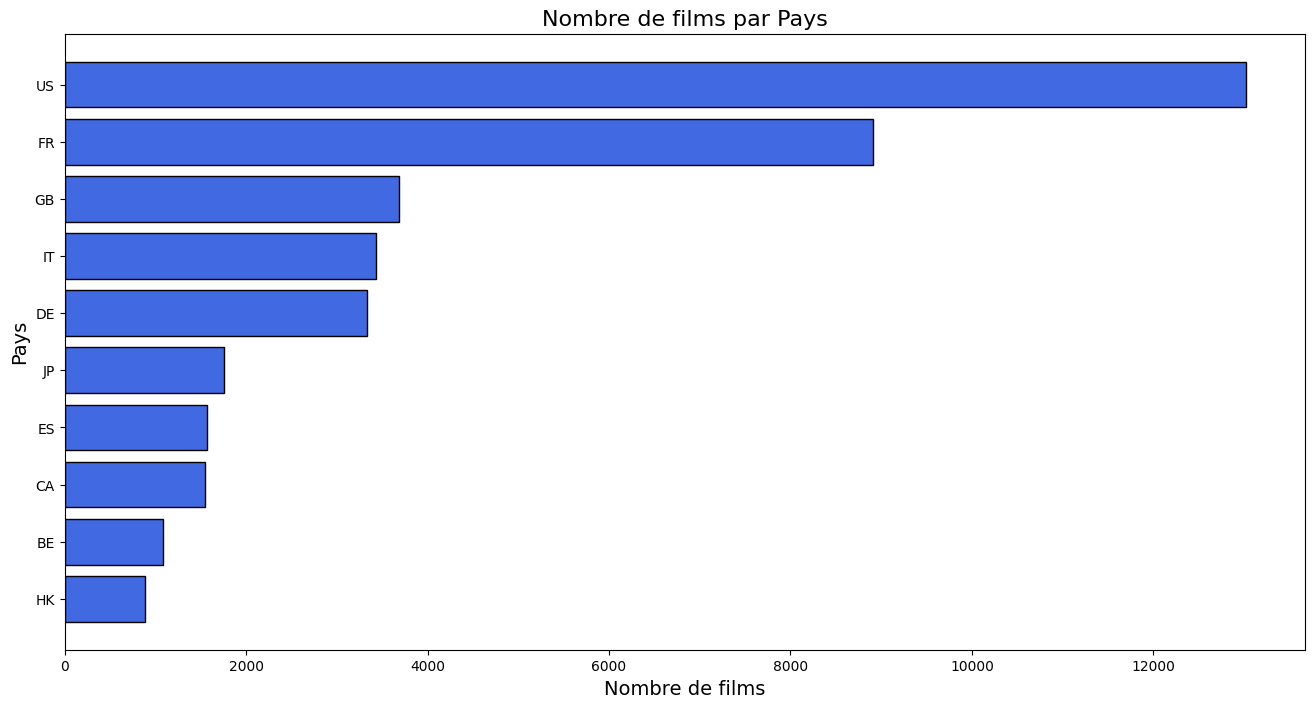

In [10]:
total = df.explode('production_countries')['production_countries'].value_counts()[:10]

plt.figure(figsize=(16, 8))
plt.barh(
    total.index,
    total.values,
    color='royalblue',
    edgecolor='black'
)
plt.title('Nombre de films par Pays', fontsize=16)
plt.xlabel('Nombre de films', fontsize=14)
plt.ylabel('Pays', fontsize=14)
plt.gca().invert_yaxis()
plt.show()

In [11]:
boxplotdf = df

boxplotdf["cuts"] = boxplotdf["cuts"].astype(str)
boxplotdf.sort_values("cuts", inplace=True)

fig = px.box(
    data_frame = boxplotdf,
    y = "titre_duree",
    color = "cuts"
)

fig.show()

In [12]:
# df.to_parquet("clean_datasets/movies_cleaned.parquet")

In [13]:
df.shape

(36229, 16)

In [14]:
# # On filtre les films qui sont déja sortie au cinéma
# year_now = datetime.now().year

# condi = (
#     (df["person_job"].str.contains("act")) &
#     (df["titre_date_sortie"] <= year_now)
# )
# df = df[condi]
# actor = df.copy()

# """
# La moyenne d'age des acteurs a la date de sortie du film.
# Nous calculons la mediane sur cette base.

# other KPI, calcul la moyenne des ages en fonction de l'année

# """
# # ajouter colonne age pour les personnes
# actor["person_age"] = np.where(
#     (actor["person_birthdate"] > 1800) &
#     (actor["titre_date_sortie"] > 1800) &
#     (actor["titre_date_sortie"] - actor["person_birthdate"] >= 0),
#     (actor["titre_date_sortie"] - actor["person_birthdate"]),
#     0
# )
# actor.tail()

In [15]:
# """
# imagine un fonction, qui prendrais en argument une liste de date de
# titre de sortie et retourne la moyenne d'age de ces années des acteurs.

# # Quels sont les acteurs les plus présents ?
# # À quelle période ?
# La durée moyenne des films s'allonge ou se raccourcit avec les années ?
# Les acteurs de série sont-ils les mêmes qu'au cinéma ?
# # Les acteurs ont en moyenne quel âge ?
# Quels sont les films les mieux notés ?
# Partagent-ils des caractéristiques communes ? etc...

# """

# bins, names = bins_generator(actor["titre_date_sortie"].max())

# actor["cuts"] = pd.cut(
#     actor["titre_date_sortie"],
#     bins=bins,
#     labels=names
# )

# actor_median = []
# for date in names[1:]:
#     condi = (
#         (actor["person_age"] != 0) &
#         (actor["cuts"] == date)
#     )
#     # print(f"Mediane for person_age {date} :", actor["person_age"][condi].median())
#     actor_median.append(actor["person_age"][condi].median())

# plt.figure(figsize=(10,6))
# plt.bar(names[1:], actor_median, color="royalblue")
# plt.xlabel("Années des film")
# plt.ylabel("Mediane")
# plt.title("Mediane acteur vs année")
# plt.xticks(rotation=45)
# plt.tight_layout()

In [16]:
# # Top 5 des acteurs all time !
# print(actor["person_name"].value_counts().head(5))
# # Bottom 5 des acteurs all time !
# print(actor["person_name"].value_counts().tail(5))

In [17]:
# # Top 5 actors by years
# for date in names[1:]:
#     top5 = actor['person_name'][condi].value_counts().head(5)
#     condi = (
#         (actor["cuts"] == date)
#     )
#     top5_str = '\n'.join(str(top5).split('\n')[:-1])

#     print(f"Top 5 actors by movies for {date}\n{'-'*20}\n{top5_str}")
#     print("-"*20)


In [18]:
# #  World record of the longest documentary
# # source :https://fr.wikipedia.org/wiki/Ambianc%C3%A9
# longest = actor[actor["titre_duree"] == 43200]
# n = longest[["titre_str", "titre_duree"]].iloc[0]
# heure = n["titre_duree"] // 60
# jours = heure // 24
# print(f"Le film le plus long est {n['titre_str']} d'une durée de {heure} heures soit {jours} jours")
# # All time median for duration
# print(f"All time duration median : {round(actor['titre_duree'].median())} minutes")

In [19]:
# # Median duration for movies between years.
# nodup = actor[~actor["titre_str"].duplicated(keep="first")]

# for date in names[1:]:
#     condi = (
#         (nodup["cuts"] == date)
#     )
#     med = round(nodup["titre_duree"][condi].median())
#     print(f"Median durations for movies {date}\nMedian for this years is {med} minutes")
#     print("-"*20)

In [20]:
# print(len(yy[yy["titre_date_sortie"].isna()]))
# yy["titre_date_sortie"].fillna(1678, inplace=True)
# yy["person_birthdate"] = yy["person_birthdate"].astype(int).replace(0, 1678)
# condi = (
#     yy["person_birthdate"] < 1678
# )

# yy.loc[condi, "person_birthdate"] = 1678
# datime_col = ["titre_date_sortie", "person_birthdate"]
# for time in datime_col:
#     yy[time] = pd.to_datetime(yy[time], format="%Y")
# yy["titre_date_sortie"] = yy["titre_date_sortie"].dt.year